
----
I separately converted the raw HEM data from the time period.  This includes six 5-minute files.  Once these are in .wav format, below I aggregate them into a single .wav for analysis.  There are a couple of notes here:
 1. The ACO files should be exactly five minutes at 24,000 Hz.  This means 7,200,000 samples in each file.  However, I think the acquisition s/w pads these files, since 24000 is not an even multiple of five minutes.  In any case, the aggregate 30-minute file should have 43,200,000 samples, but it has a few more.  Here, I simply __truncate__ to get 43,200,000 samples exactly, then __adjust__ the time vector to start/end at the right time.
 2. The specgram function in matplotlib is used.  This returns the scaled power spectrum in decibells; in other words, it plots 10 * log10 of the amplitudes.  You can also scale this via the kwarg _scale_: 'linear' is no scaling. 'dB' returns the values in dB scale. When mode is 'psd', this is dB power (10 * log10). Otherwise, this is dB amplitude (20 * log10). 'default' is 'dB' if mode is 'psd' or 'magnitude' and 'linear' otherwise. This must be 'linear' if mode is 'angle' or 'phase'.


In [1]:
import numpy as np

from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.dates import DateFormatter
import matplotlib.colors as mpl_colors
import matplotlib.dates as md

import calendar

from scipy.io import wavfile
from scipy.signal import butter,filtfilt
import wave

In [2]:
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

## Create the aggregated wav file
I aggregate the individual, 5-minute files into a single file.  Note that this only needs to be done one (set run_cat = True).  This will save the aggregated file for later use, so subsequent runs can be done with run_cat = False

In [3]:
outfile = './data/sample.wav'
infiles = ['2024-01-26--19.50.wav', '2024-01-26--19.55.wav', '2024-01-26--20.00.wav',
           '2024-01-26--20.05.wav', '2024-01-26--20.10.wav', '2024-01-26--20.15.wav']

data= []
for infile in infiles:
    w = wave.open('./data/' + infile, 'rb')
    data.append( [w.getparams(), w.readframes(w.getnframes())] )
    w.close()
    
output = wave.open(outfile, 'wb')
output.setparams(data[0][0])
for i in range(len(data)):
    output.writeframes(data[i][1])
output.close()

## Read the input file
As noted above, the aggregate file may be longer than sample_rate * time_range.  Below, I just truncate the aggregate file to match exactly.  I believe a __better way__ to do this would be truncate each individual file first, then aggregate.

Next I create a datetime array to hold the time values.

In [4]:
# read input file
hem_sample_rate, hem_samples = wavfile.read(outfile)

# find how many samples should there be, given the sample rate
nsamples = len(hem_samples) - int(len(hem_samples)/hem_sample_rate) * hem_sample_rate

# truncate file to be exact length
hem_samples = hem_samples[:-nsamples]

# create time array
hem_time = datetime(2024,1,26,19,50) + np.arange(len(hem_samples)) * timedelta(milliseconds=1/hem_sample_rate*1000)
cdate = calendar.month_name[hem_time[0].month] + ' ' + str(hem_time[0].day) + ', ' + str(hem_time[0].year)

hem_lp = butter_lowpass_filter(hem_samples, 0.5, hem_sample_rate, 2)

## Plot the raw data
Note: this takes a while to generate the plot...

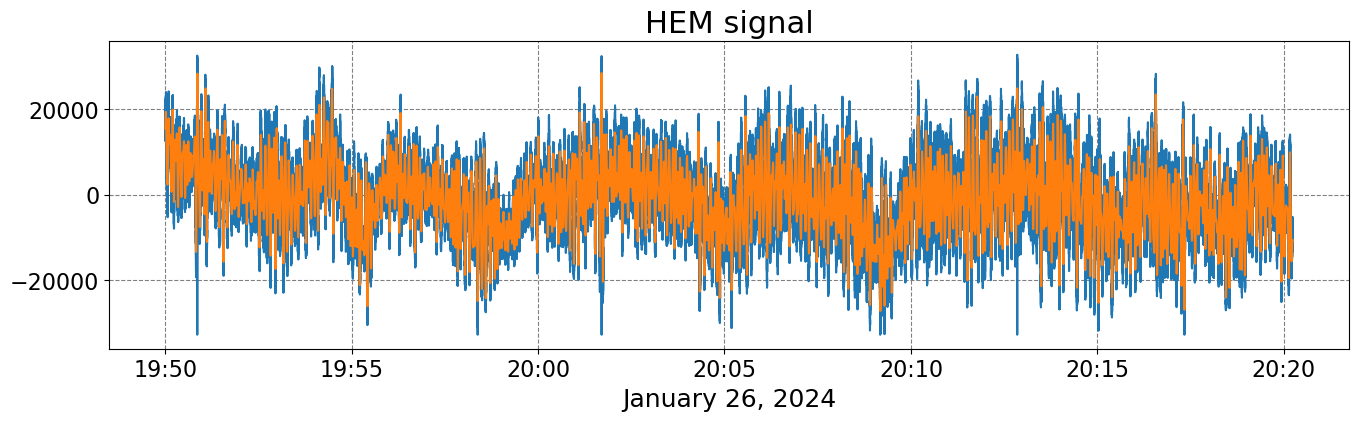

In [5]:
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(hem_time,hem_samples)
ax.plot(hem_time,hem_lp)
ax.grid(color='grey',linestyle='dashed')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_xlabel(cdate, fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('HEM signal', fontsize=22);

## Plot spectrogram

In [6]:
# define color-range
vmin, vmax = 10, 40
norm = mpl_colors.Normalize(vmin=vmin, vmax=vmax)

# set color map 
cmap1 = plt.colormaps['magma']
cmap2 = plt.colormaps['hot']
cmap3 = plt.colormaps['inferno']

In [7]:
pxx, freq, t = mlab.specgram(hem_samples,NFFT=int(2.0*hem_sample_rate), Fs=hem_sample_rate)
dt = 30.001 * 60.0 / len(t)
spec_time = np.arange(datetime(2024,1,26,19,50), datetime(2024,1,26,20,20), timedelta(seconds=dt)).astype(datetime)

In [8]:
horizontal = False
if horizontal:
    X = spec_time
    Y = freq
    Z = 10*np.log10(np.abs(pxx))
else:
    X = freq
    Y = spec_time
    Z = signal = 10*np.log10(np.abs(pxx)).T

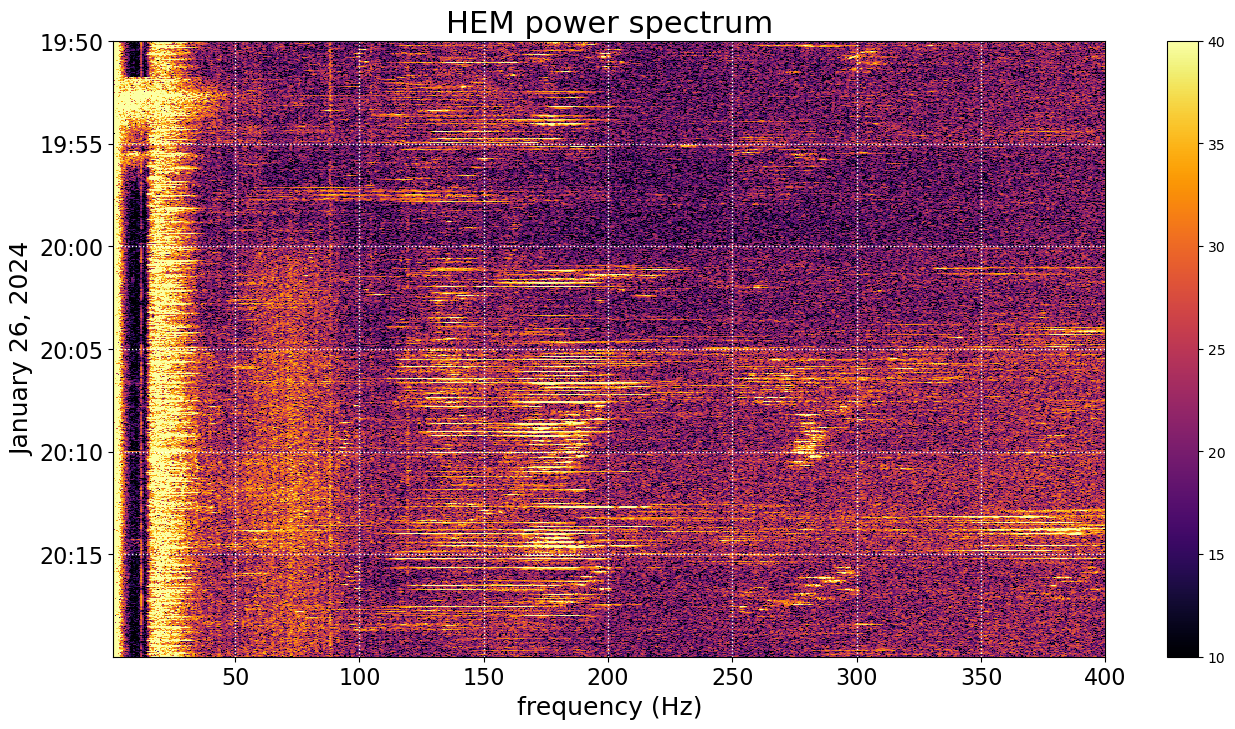

In [9]:
fig, ax = plt.subplots(figsize=(16,8))

cs = ax.pcolormesh(X, Y, Z, shading='auto', norm=norm, cmap=cmap3)
if horizontal:
    ax.set_xlabel(cdate, fontsize=18)
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.set_ylabel('frequency (Hz)', fontsize=18)
    ax.set_ylim([1,400])
else:   
    ax.invert_yaxis()
    ax.set_xlabel('frequency (Hz)', fontsize=18)
    ax.set_xlim([1,400])
    ax.set_ylabel(cdate, fontsize=18)
    ax.yaxis.set_major_formatter(md.DateFormatter('%H:%M'))

ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid(color='white',linestyle='dotted',linewidth=1)
ax.set_title('HEM power spectrum', fontsize=22)
fig.colorbar(cs,norm=norm);

In [10]:
time_res = 0.0001
P = 30 * 60
RATE = 1/time_res
time = np.linspace(0,P,int(RATE*P))
spec = np.abs(np.fft.rfft(hem_samples))
f = np.linspace(0, RATE/2, len(spec))

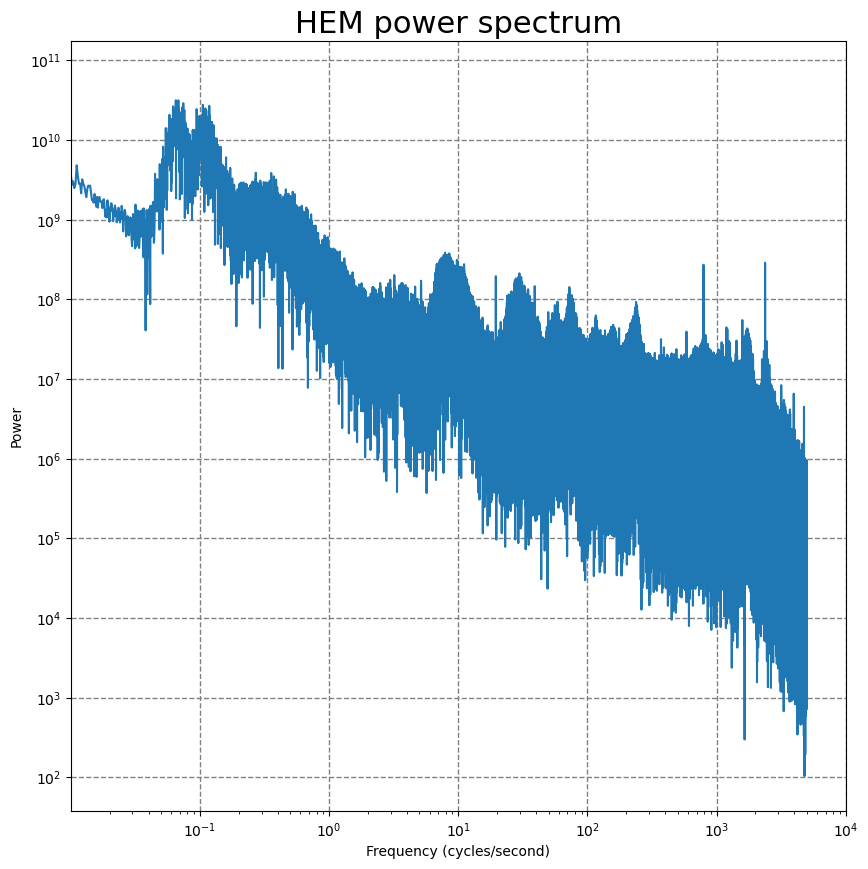

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax.loglog(f,spec)
ax.set_xlim([10e-3,10e3])
ax.set_yticks([10e1,10e2,10e3,10e4,10e5,10e6,10e7,10e8,10e9,10e10]) 
ax.set_xticks([10e-2,10e-1,10e0,10e1,10e2,10e3]) 
ax.set_xlabel('Frequency (cycles/second)')
ax.set_ylabel('Power')
ax.grid(color='grey',linestyle='dashed',linewidth=1)
ax.set_title('HEM power spectrum', fontsize=22);